## Problema

En aplicaciones reales, como redes de transporte, logística o infraestructura, los **pesos de los arcos** de un grafo no son constantes, sino que pueden variar dentro de un rango \([min, max]\) debido a factores como:

- **Tráfico**
- **Estado de la vía**
- **Condiciones climáticas**

Adicionalmente, cada vía tiene asociado un **estado** que puede ser:

- Habilitada
- Cerrada
- Presenta grietas o hundimientos
- Otros estados relevantes

Estos estados pueden:

- **Invalidar temporalmente una ruta**
- **Modificar el promedio del rango efectivo de peso**

Por lo tanto, el problema consiste en modelar y analizar rutas óptimas considerando tanto la **variabilidad de los pesos** como el **estado dinámico de las vías**, lo que añade complejidad y realismo a la toma de decisiones en la gestión de redes.

## Solución 

### Estructura de Datos Aumentada

In [1]:
class Arista:
    def __init__(self, u, v, tiempo_min, tiempo_max, estado):
        self.u = u                      # Vértice origen
        self.v = v                      # Vértice destino
        self.tiempo_min = tiempo_min    # Tiempo estimado mínimo
        self.tiempo_max = tiempo_max    # Tiempo estimado máximo
        self.estado = estado            # Estado de la vía

    def costo(self):
        if self.estado == "cerrado":
            return float('inf')
        variabilidad = self.tiempo_max - self.tiempo_min
        if self.estado == "habilitado":
            penalizacion = 0
        elif self.estado == "con_grietas":
            penalizacion = 5
        elif self.estado == "con_hundimientos":
            penalizacion = 10
        else:
            penalizacion = 20
        return self.tiempo_max + variabilidad + penalizacion


class Grafo:
    def __init__(self):
        self.V = set()      # Conjunto de vértices
        self.E = []         # Lista de aristas
        self.ADJ = {}       # Diccionario de listas de adyacencia

    def agregar_vertice(self, v):
        if v not in self.V:
            self.V.add(v)
            self.ADJ[v] = []

    def agregar_arista(self, u, v, tiempo_min, tiempo_max, estado):
        if u not in self.V or v not in self.V:
            raise ValueError("Uno o ambos vértices no existen")
        e = Arista(u, v, tiempo_min, tiempo_max, estado)
        self.E.append(e)
        self.ADJ[u].append(e)
        self.ADJ[v].append(e)

    def actualizar_estado(self, e, nuevo_estado):
        e.estado = nuevo_estado

    def modificar_rango(self, e, nuevo_min, nuevo_max):
        e.tiempo_min = nuevo_min
        e.tiempo_max = nuevo_max


class UnionFind:
    def __init__(self, vertices):
        self.parent = {v: v for v in vertices}

    def find(self, v):
        if self.parent[v] != v:
            self.parent[v] = self.find(self.parent[v])
        return self.parent[v]

    def union(self, u, v):
        pu, pv = self.find(u), self.find(v)
        if pu != pv:
            self.parent[pu] = pv



### Algoritmo de Kruskal

In [2]:
def kruskal(grafo):
    A = []  # Árbol de expansión mínima (MST)
    uf = UnionFind(grafo.V)  # Inicializar estructura de conjuntos disjuntos

    # Ordenar aristas por su costo, excluyendo las que están "cerradas"
    aristas_ordenadas = sorted(
        [e for e in grafo.E if e.costo() < float('inf')],
        key=lambda e: e.costo()
    )

    for e in aristas_ordenadas:
        if uf.find(e.u) != uf.find(e.v):
            A.append(e)
            uf.union(e.u, e.v)

    return A

### Visualización


In [42]:
pip install networkx matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# def visualizar_grafo(grafo, aristas_destacadas=None):
#     G = nx.Graph()

#     Añadir nodos
#     for v in grafo.V:
#         G.add_node(v)

#     Añadir aristas con pesos
#     for e in grafo.E:
#         if e.costo() < float('inf'):
#             G.add_edge(e.u, e.v, weight=round(e.costo(), 1))

#     pos = nx.spring_layout(G, seed=42)  # Posiciones fijas

#     Dibujar nodos
#     nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
    
#     Dibujar etiquetas de nodos
#     nx.draw_networkx_labels(G, pos)

#     Dibujar todas las aristas en gris
#     nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)

#     Resaltar aristas del MST si se pasa una lista
#     if aristas_destacadas:
#         edges_destacadas = [(e.u, e.v) for e in aristas_destacadas]
# print(f"Aristas destacadas: {edges_destacadas}")  # Debug
#         nx.draw_networkx_edges(G, pos, edgelist=edges_destacadas, edge_color='red', width=3)

#     # Etiques de los pesos
#     edge_labels = nx.get_edge_attributes(G, 'weight')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

#     plt.title("Grafo con pesos y MST (rojo)")
# plt.axis('off')  # Quitar ejes
#     plt.show()

# Función alternativa con más control visual
def visualizar_grafo_detallado(grafo, aristas_destacadas=None):
    G = nx.Graph()
    
    # Añadir nodos
    for v in grafo.V:
        G.add_node(v)
    
    # Añadir aristas con información detallada
    for e in grafo.E:
        if e.costo() < float('inf'):
            G.add_edge(e.u, e.v, 
                      weight=round(e.costo(), 1),
                      estado=e.estado,
                      rango=f"({e.tiempo_min}-{e.tiempo_max})")
    
    # Crear figura más grande
    plt.figure(figsize=(12, 8))
    
    pos = nx.spring_layout(G, seed=42, k=3, iterations=50)
    
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=1000, alpha=0.7)
    
    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Dibujar todas las aristas normales
    todas_aristas = list(G.edges())
    nx.draw_networkx_edges(G, pos, edgelist=todas_aristas, 
                          edge_color='gray', width=1, alpha=0.5)
    
    # Resaltar aristas del MST
    if aristas_destacadas:
        edges_mst = [(e.u, e.v) for e in aristas_destacadas]
        print(f"🔍 Aristas del MST a destacar: {edges_mst}")
        
        # Dibujar aristas destacadas con color rojo y más grosor
        nx.draw_networkx_edges(G, pos, edgelist=edges_mst, 
                              edge_color='red', width=4, alpha=0.8)
        
        # Calcular costo total del MST
        costo_total = sum(e.costo() for e in aristas_destacadas)
        print(f"💰 Costo total del MST: {costo_total:.1f}")
    
    # Etiquetas de pesos
    edge_labels = {}
    for e in grafo.E:
        if e.costo() < float('inf'):
            edge_labels[(e.u, e.v)] = f"{e.costo():.1f}"
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=10, bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor="white", alpha=0.8))
    
    plt.title("Grafo con MST destacado (Algoritmo de Kruskal)", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Mostrar información adicional
    if aristas_destacadas:
        print("\n📋 Detalles de las aristas del MST:")
        for i, e in enumerate(aristas_destacadas, 1):
            print(f"  {i}. {e.u} -- {e.v} | Estado: {e.estado} | "
                  f"Rango: ({e.tiempo_min}, {e.tiempo_max}) | Costo: {e.costo():.1f}")



🎨 VISUALIZACIÓN DETALLADA:
🔍 Aristas del MST a destacar: [('Mall del Sol', 'San Marino'), ('Espol', 'R. Ceibos'), ('R. Ceibos', 'San Marino'), ('Malecon 2000', 'San Marino')]
💰 Costo total del MST: 24.0


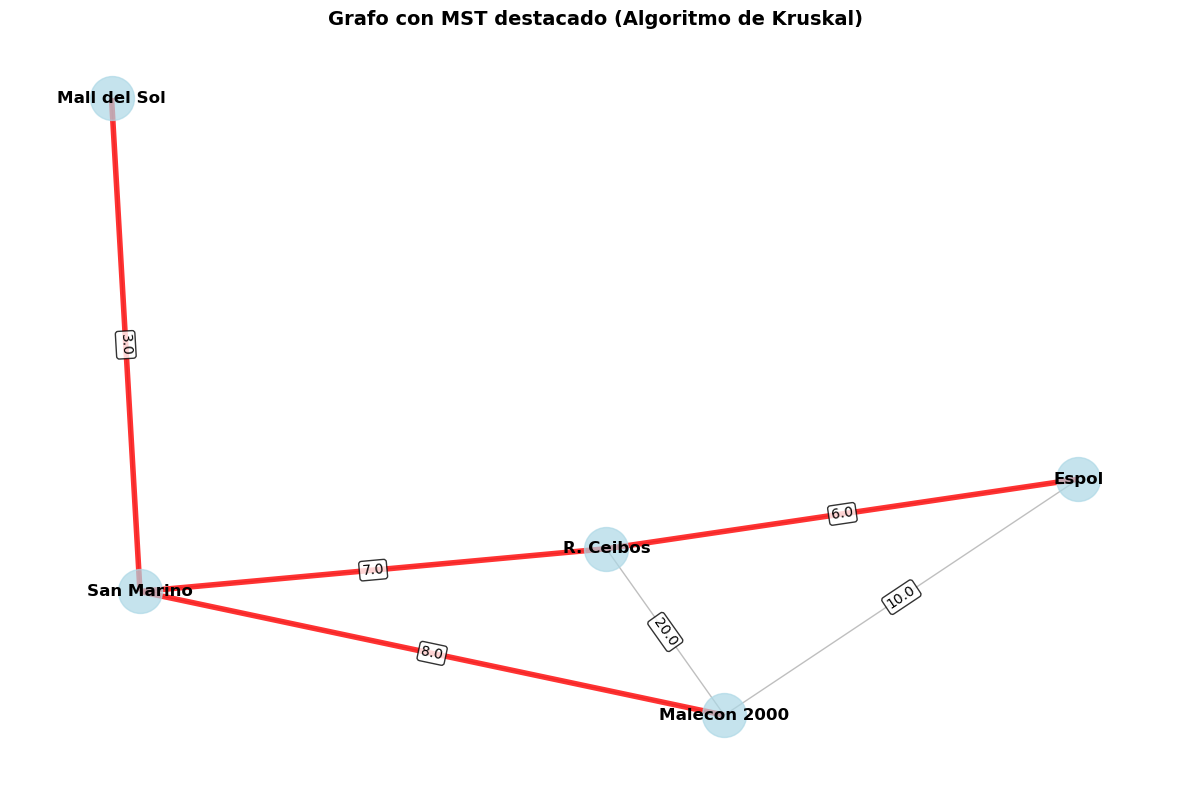


📋 Detalles de las aristas del MST:
  1. Mall del Sol -- San Marino | Estado: habilitado | Rango: (1, 2) | Costo: 3.0
  2. Espol -- R. Ceibos | Estado: habilitado | Rango: (2, 4) | Costo: 6.0
  3. R. Ceibos -- San Marino | Estado: habilitado | Rango: (3, 5) | Costo: 7.0
  4. Malecon 2000 -- San Marino | Estado: habilitado | Rango: (2, 5) | Costo: 8.0


In [67]:
g = Grafo()
for v in ['Espol', 'R. Ceibos','Malecon 2000','San Marino','Mall del Sol']:
    g.agregar_vertice(v)

g.agregar_arista('Espol', 'R. Ceibos', 2, 4, 'habilitado')
g.agregar_arista('Espol', 'Malecon 2000', 1, 3, 'con_grietas')
g.agregar_arista('R. Ceibos', 'Malecon 2000', 2, 6, 'con_hundimientos')
g.agregar_arista('Mall del Sol', 'San Marino', 1, 2, 'habilitado')  # Ignorada
g.agregar_arista('R. Ceibos', 'San Marino', 3, 5, 'habilitado')
g.agregar_arista('Malecon 2000', 'San Marino', 2, 5, 'habilitado')



# Calcular MST
mst = kruskal(g)

print("\n🎨 VISUALIZACIÓN DETALLADA:")
visualizar_grafo_detallado(g, aristas_destacadas=mst)
